### Transfer learning

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import datetime
import keras
import os
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [2]:
# Loads Tensorboard
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

'rm' is not recognized as an internal or external command,
operable program or batch file.


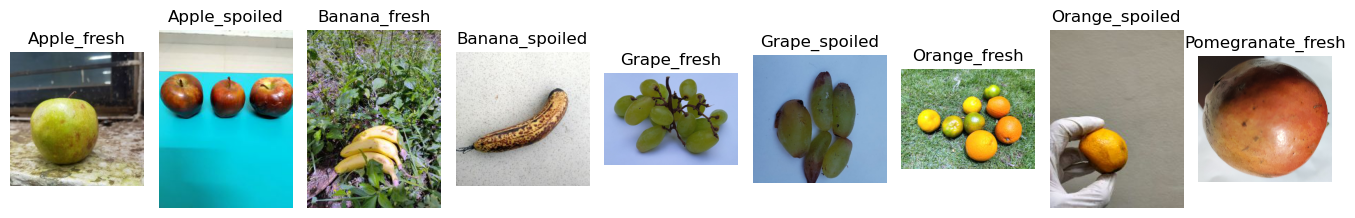

Size of image 100: (2626, 2772, 3)


In [3]:
# Specify the path for the datasets
dataset_dir = 'path/to/dataset'
train_path_quality = os.path.join(dataset_dir, 'Fruit-quality-dataset/Train')
test_path_quality = os.path.join(dataset_dir, 'Fruit-quality-dataset/Test')

qfruits = ['Apple_fresh', 'Apple_spoiled', 'Banana_fresh', 'Banana_spoiled', 'Grape_fresh', 'Grape_spoiled', 'Orange_fresh', 'Orange_spoiled', 'Pomegranate_fresh', 'Pomegranate_spolied']

# Which image in the folder
fruitnr = 100

plt.figure(figsize=(15, 10))
num_fruits = len(qfruits)

for i, fruit in enumerate(qfruits):
    fruit_path = os.path.join(train_path_quality, fruit)
    
    # Cycle through all subdirectories and files in the fruit_path
    for root, dirs, files in os.walk(fruit_path):
        # Get the file path of the desired image
        img_path = os.path.join(root, files[fruitnr - 1])
        
        # Load the image
        img = load_img(img_path)
        
        # Create a subplot for the current fruit image
        plt.subplot(1, num_fruits, i+1)
        plt.imshow(img)
        plt.title(fruit)
        plt.axis('off')
        break  # Break after processing the first image

plt.tight_layout()
plt.show()

print("Size of image {fruitnr}:".format(fruitnr=fruitnr), img_to_array(img).shape)

In [6]:
# Specify image dimensions for the network
img_height, img_width, channels = 100, 100, 3

# Define the training configurations
LEARNING_RATE = 0.001 # 0.0001
BATCH_SIZE = 16
ROTATION_RANGE = 0 # No rotation
ZOOM_RANGE = 0 # 0.3
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Choose transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='constant',
    cval=255,
    rotation_range=ROTATION_RANGE,
    zoom_range=ZOOM_RANGE,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    # preprocessing_function=add_monochromatic_blocks
) # Add random cropping, horizontal flipping, or adjusting brightness/contrast?
test_datagen  = ImageDataGenerator(rescale = 1./255)

# Convert the learning rate and shear range to strings without the decimal point
learning_rate_str = str(LEARNING_RATE).replace(".", "")

In [7]:
# Get the list of subdirectories and count the number of subdirectories
subdirectories = [f.path for f in os.scandir(train_path_quality) if f.is_dir()]
num_qclasses = len(subdirectories)

# Set model filename
model_name = f"fruit_model_lr{learning_rate_str}_bs{BATCH_SIZE}_rr{ROTATION_RANGE}_zr{ZOOM_RANGE}.h5"
print(model_name)

# Must have an .h5-file from the Fruits360 training
model = load_model(os.path.join('360_models', model_name))

model.pop()  # Remove the last layer

# Changes from 5 to 10 classes and adds a softmax in the end
model.add(Dense(num_qclasses, activation='softmax'))

model.summary(expand_nested=True, show_trainable=True)

fruit_model_lr0001_bs16_rr0_zr0.h5
Model: "sequential_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_2 (InputLayer)      [(None, 100, 100, 3)]     0         Y          |
|                                                                          |
| block1_conv1 (Conv2D)     (None, 100, 100, 64)      1792      Y          |
|                                                                          |
| block1_conv2 (Conv2D)     (None, 100, 100, 64)      36928     Y          |
|                                                                          |
| block1_pool (MaxPooling2D)  (None, 50, 50, 64)      0         Y          |
|                                                                          |
| block2_conv1 (Con

In [8]:
# Generates batches of augmented training and test data from directory
train_generator_quality = train_datagen.flow_from_directory(
    train_path_quality,
    target_size = (img_height,img_width),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "training")
validation_generator_quality = train_datagen.flow_from_directory(
    train_path_quality,
    target_size = (img_height,img_width),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "validation")
test_generator_quality = test_datagen.flow_from_directory(
    test_path_quality,
    target_size = (img_height,img_width),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical")

Found 15693 images belonging to 10 classes.
Found 3918 images belonging to 10 classes.
Found 1215 images belonging to 10 classes.


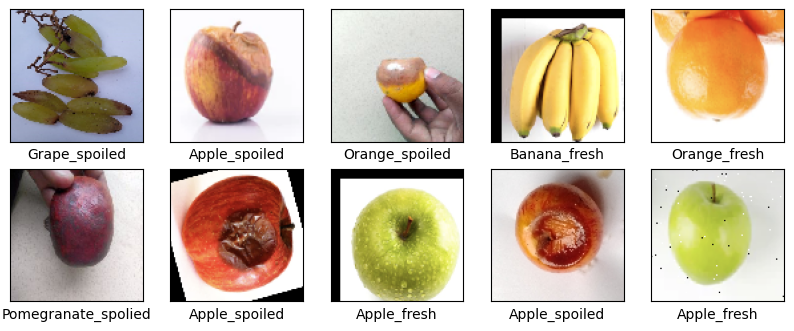

In [9]:
# Generate a batch of augmented images
augmented_images, labels = train_generator_quality.next()

# Limit the number of images to display
num_images = min(augmented_images.shape[0], 10)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(augmented_images[i])
    plt.xlabel(qfruits[np.argmax(labels[i] == 1)])
plt.show()

Saving the best validation result to val_result.txt

In [10]:
class SaveValidationMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath, model_identifier):
        super(SaveValidationMetricsCallback, self).__init__()
        self.filepath = filepath
        self.model_identifier = model_identifier
        self.previous_model_identifier = None
        self.best_metrics = None
        self.best_epoch = None

    def on_epoch_end(self, epoch, logs=None):
        # Check if the validation metrics are available in the logs dictionary
        if 'val_loss' in logs and 'val_accuracy' in logs and 'val_recall' in logs and 'val_precision' in logs:
            # Retrieve validation metrics from the logs
            val_loss = logs['val_loss']
            val_accuracy = logs['val_accuracy']
            val_recall = logs['val_recall']
            val_precision = logs['val_precision']

            # Check if the current model is different from the previous model
            if self.model_identifier != self.previous_model_identifier:
                # If it's a new model, save the validation metrics to a new line
                self.save_validation_metrics(val_loss, val_accuracy, val_recall, val_precision, epoch)
            else:
                # If it's the same model, overwrite the last line with updated validation metrics
                self.overwrite_validation_metrics(val_loss, val_accuracy, val_recall, val_precision, epoch)

            # Update the previous model identifier for the next epoch
            self.previous_model_identifier = self.model_identifier

            # Check if the current metrics are the best so far
            if self.best_metrics is None or val_loss < self.best_metrics[0]:
                self.best_metrics = (val_loss, val_accuracy, val_recall, val_precision)
                self.best_epoch = epoch

    def save_validation_metrics(self, val_loss, val_accuracy, val_recall, val_precision, epoch):
        # Open the file in append mode and write the validation metrics to a new line
        with open(self.filepath, 'a') as file:
            file.write(f"{self.model_identifier},"
                       f"Epoch={epoch + 1},"
                       f"Loss={val_loss:.4f},"
                       f"Accuracy={val_accuracy:.4f},"
                       f"Recall={val_recall:.4f},"
                       f"Precision={val_precision:.4f}\n")

    def overwrite_validation_metrics(self, val_loss, val_accuracy, val_recall, val_precision, epoch):
        # Open the file in read and write mode
        with open(self.filepath, 'r+') as file:
            # Read all lines from the file
            lines = file.readlines()
            # Move the file cursor to the beginning of the file
            file.seek(0)
            # Write all lines except the last line (overwrite the previous result)
            for line in lines[:-1]:
                file.write(line)
            # Write the updated validation metrics to the last line
            file.write(f"{self.model_identifier},"
                       f"Epoch={epoch + 1},"
                       f"Loss={val_loss:.4f},"
                       f"Accuracy={val_accuracy:.4f},"
                       f"Recall={val_recall:.4f},"
                       f"Precision={val_precision:.4f}\n")


# Specify the path for saving the validation results
validation_results_file = "val_results.txt"

model_name_quality = f"transfer_fruit_model_lr{learning_rate_str}_bs{BATCH_SIZE}_rr{ROTATION_RANGE}_zr{ZOOM_RANGE}.h5"

# Create an instance of the SaveValidationMetricsCallback
validation_metrics_callback = SaveValidationMetricsCallback(validation_results_file, model_name_quality)

Saving the best validation model to quality_models folder

In [11]:
# Create the "quality_models" subdirectory if it doesn't exist
if not os.path.exists("quality_models"):
    os.makedirs("quality_models")

# Specify the path for saving the best model
model_path = os.path.join("quality_models", model_name_quality)

# Save the best model the model after every epoch
checkpointer_callback = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    save_weights_only=False,
    save_best_only=True,
    verbose=1
)

In [12]:
# Reduces learning rate on performance plateau.
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', # It monitors the validation loss to determine whether to reduce the learning rate.
    factor=0.1, # The learning rate is multiplied by this factor when triggered.
    patience=3, # Number of epochs with no improvement after which the learning rate will be reduced.
    min_lr=0.00001, # Lower bound on the learning rate.
    verbose=1 # Controls the level of detail in output messages.
)

# Stops training when monitored metric stops improving.
earlyStop_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_loss'
)

# TensorBoard logs for visualizing training progress.
log_dir = "logs/quality/" + model_name_quality + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

callbacks = [
    checkpointer_callback,
    earlyStop_callback,
    tensorboard_callback,
    reduce_lr_callback,
    validation_metrics_callback
]

In [13]:
# Configures the model for training
model.compile(
    loss="categorical_crossentropy",
    optimizer = OPTIMIZER,
    metrics = ["Accuracy", "Recall", "Precision"]
)

In [ ]:
# Train the model with specified settings and callbacks.
hist = model.fit(
    train_generator_quality,
    epochs = 50,
    validation_data = validation_generator_quality,
    callbacks = callbacks
)

Generate a plot of the loss

In [ ]:
# Get the training history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Generate confusion matrix on the test set with the best model

In [ ]:
# Load the best model
best_model = load_model(os.path.join('quality_models', model_name_quality))

# Evaluate the model
y_true = test_generator_quality.classes
y_pred = best_model.predict(test_generator_quality)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(num_qclasses), labels=qfruits, rotation=45)
plt.yticks(ticks=np.arange(num_qclasses), labels=qfruits, rotation=0)
plt.show()

Evaluate the best model and save the test result to model_acc.txt

In [ ]:
# Evaluate the model
test_acc = best_model.evaluate(test_generator_quality, verbose=2)

# Get the evaluation results with 4 decimal places
loss = round(test_acc[0], 4)
accuracy = round(test_acc[1], 4)
recall = round(test_acc[2], 4)
precision = round(test_acc[3], 4)

# Write the results to a string
result_string = f"-Loss={loss:.4f}, Accuracy={accuracy:.4f}, Recall={recall:.4f}, Precision={precision:.4f}"

# Get the optimizer, learning rate, batch size, and transformations used
optimizer_name = model.optimizer.__class__.__name__
transformations = {
    key: value
    if key != 'rescale' else f"{1/value:.4f}"
    for key, value in train_datagen.__dict__.items()
    if key in ['rescale', 'fill_mode', 'cval', 'shear_range', 'rotation_range', 'zoom_range', 'validation_split']
    and value is not None and value != 0 and not callable(value)
}

# Write the additional information to a string
additional_info = (
    f"Optimizer={optimizer_name}, Learning Rate={LEARNING_RATE:.4f}, Batch Size={BATCH_SIZE},"
    f" Transformations={transformations}"
)

# Check if the file exists
if os.path.exists("model_acc.txt"):
    # If the file exists, open it in append mode
    with open("model_acc.txt", "a") as file:
        # Write the results to the file with 4 decimal places
        file.write(f"{result_string}, {additional_info}\n")
else:
    # If the file does not exist, create it and write the results
    with open("model_acc.txt", "w") as file:
        # Write the results to the file with 4 decimal places
        file.write(f"{result_string}, {additional_info}\n")

76/76 - 46s - loss: 1.5905 - Accuracy: 0.5317 - recall: 0.4765 - precision: 0.5699 - 46s/epoch - 604ms/step


In [ ]:
# Launces application 'Tensorboard' that compiles all data from code-run in file path 'logs'
%tensorboard --logdir logs --port=6006 # 8008